# SMART BILLING TRAIN:

Overview : We use an AI-based approach for retail billing, significantly reducing retail checkout times. Our model accurately detects multiple objects simultaneously, instantly generating bills at the click of a button. Customer satisfaction is vastly improved, leading to better sales, as they no longer need to wait for each item to be manually scanned before the bill is generated.

We use an object detection model based on the Faster RCNN architecture to detect items from an image of the checkout counter.This notebook contains steps to train the object detector.

Below is a link to a folder containing the training data :

https://drive.google.com/drive/folders/10L1PLtX46ANJJ_RafmIREqSmqkeRz6_4?usp=sharing

To use it , please do add it to your drive.


## Installing detectron2


---
We use Detectron2, an open source system that implements state-of-the-art object detection algorithms. It is built upon the PyTorch framework.

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 2.5MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 3.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=64eabf5f6b7fc74e8bbe656f809463ff628703ce8aec24286d7c18ec747fb38b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-88plxs4w
  Running command git c

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 995kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200323-cp36-none-any.whl size=38927 sha256=07672393410491b78356b694785777e906d1e9a46622809122e1ab5280117f5d
  Stored in directory: /root/.cache/pip/wheels/e3/c8/aa/78d7772d58ff8dce168061a000024b217039075055ac8c6a8e
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Using faster rcnn config from detectron2 

---
We use a Faster RCNN based model with Resnet-101 as the feature extractor.
Detectron2's model zoo allows us to initialise our model with weights from an object detector pretrained on the MS-COCO object detection dataset.

In [0]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
pred = DefaultPredictor(cfg)

## Preparing the dataset

---
We use the Retail Product Checkout dataset([link here](https://rpc-dataset.github.io/#5-Leaderboard)).
Training images and their ground truth annotations in COCO format are contained in `traindata2019` folder and `train.json` file respectively.

In [0]:
# Mounting drive so that shared folder can be used
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Replace with path to the shared folder in your drive
root_path = "/content/drive/My Drive/TECHNOUTSAV"

In [0]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

#Reading train and test data in COCO format
register_coco_instances("rpc_train", {}, os.path.join(root_path,"train.json"), os.path.join(root_path,"traindata2019"))
register_coco_instances("rpc_test", {}, os.path.join(root_path,"test.json"), os.path.join(root_path,"testdata2019"))

rpc_train_metadata = MetadataCatalog.get("rpc_train")
rpc_test_metadata = MetadataCatalog.get("rpc_test")


**Please note the following cell may give an error. This is because of colab instance timeout due to large number of images in test set. Please try running the cell again or restarting the runtime.**

[03/23 14:30:42 d2.data.datasets.coco]: Loading /content/drive/My Drive/TECHNOUTSAV/test.json takes 1.04 seconds.
[03/23 14:30:42 d2.data.datasets.coco]: Loaded 6000 images in COCO format from /content/drive/My Drive/TECHNOUTSAV/test.json


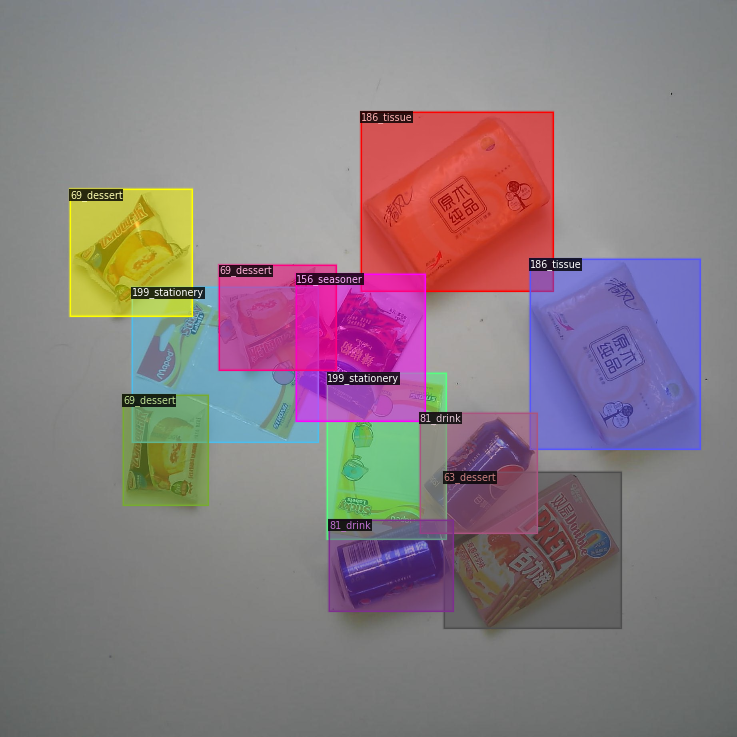

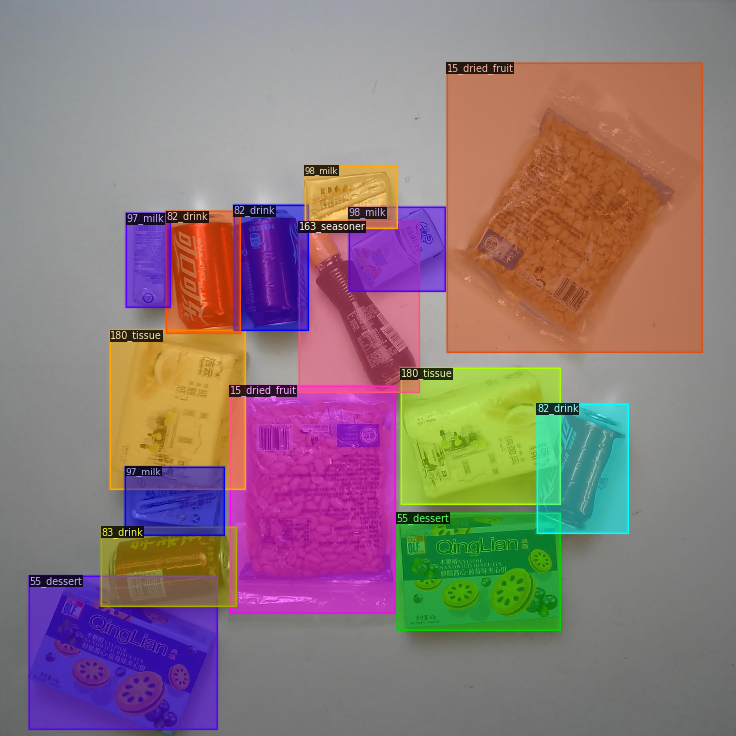

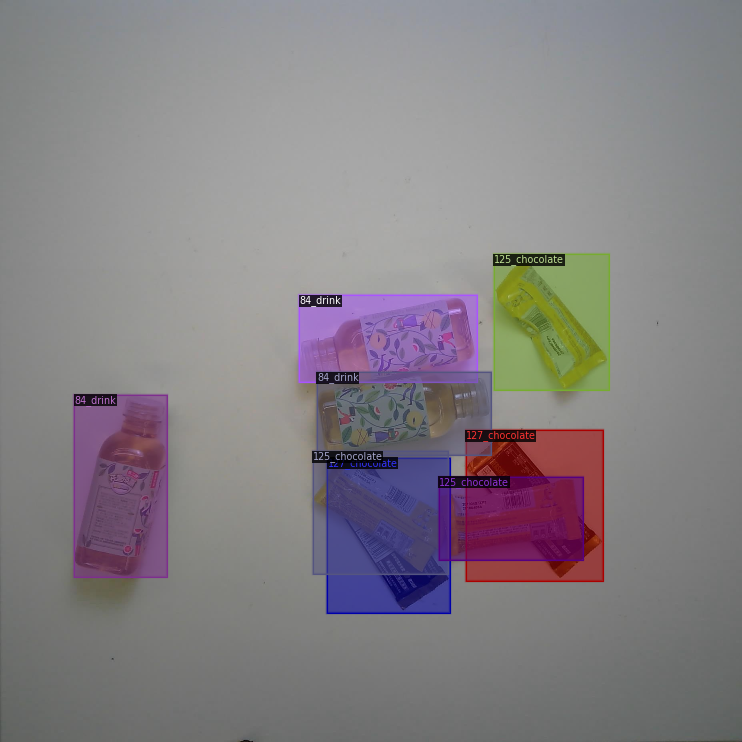

In [0]:
#Visualize 3 samples from the test data
dataset_dicts = DatasetCatalog.get("rpc_test")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=rpc_test_metadata, scale=0.4)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training

We initialise training from pretrained weights in the detectron2 model zoo. Training this on the RPC dataset for 5000 epochs takes around 2 hrs.
Training curves are visualized using TensorBoard.

The trained model is found in the `output` folder.

**Please note , running the following cell may give an OSError. This is because of the large number of training images which may not be handled properly by colab. Please Factory Reset Runtime or Restart Runtime and try again.**

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rpc_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  
cfg.SOLVER.MAX_ITER = 1000    # For better results change to 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 128 images per batch
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 200  # The RPC dataset contains 200 product categories

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # The trained model and chekcpoints will be saved in the folder /content/output
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False) # Load weights from model zoo
trainer.train()

[03/23 14:03:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (201, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (201,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (800, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (800,) in the model! Skipped.


[03/23 14:03:24 d2.engine.train_loop]: Starting training from iteration 0
[03/23 14:03:51 d2.utils.events]:  eta: 0:22:33  iter: 19  total_loss: 6.084  loss_cls: 5.129  loss_box_reg: 0.864  loss_rpn_cls: 0.051  loss_rpn_loc: 0.050  time: 1.3297  data_time: 0.0595  lr: 0.000050  max_mem: 3520M
[03/23 14:04:18 d2.utils.events]:  eta: 0:21:46  iter: 39  total_loss: 4.634  loss_cls: 3.669  loss_box_reg: 0.909  loss_rpn_cls: 0.038  loss_rpn_loc: 0.046  time: 1.3328  data_time: 0.0059  lr: 0.000100  max_mem: 3520M
[03/23 14:04:45 d2.utils.events]:  eta: 0:21:19  iter: 59  total_loss: 2.849  loss_cls: 1.932  loss_box_reg: 0.896  loss_rpn_cls: 0.020  loss_rpn_loc: 0.046  time: 1.3362  data_time: 0.0068  lr: 0.000150  max_mem: 3520M
[03/23 14:05:18 d2.utils.events]:  eta: 0:21:12  iter: 79  total_loss: 2.664  loss_cls: 1.699  loss_box_reg: 0.922  loss_rpn_cls: 0.008  loss_rpn_loc: 0.034  time: 1.4207  data_time: 0.2742  lr: 0.000200  max_mem: 3520M
[03/23 14:05:47 d2.utils.events]:  eta: 0:20:5

In [0]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output

## Testing performance of trained model : 


---
The above trained model is tested on images randomly sampled from the test dataset.


In [0]:
# Create Default Predictor
from detectron2.engine import DefaultTrainer,DefaultPredictor
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rpc_train",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 200
 
cfg.MODEL.WEIGHTS = os.path.join('/content/output','model_final.pth')
# Uncomment the below line to use an object detector which has already been trained for 5000 epochs
# cfg.MODEL.WEIGHTS = os.path.join(root_path,"smart_billing_model/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model. For a model trained for 1000 epochs set to 0.3 to see results. 
cfg.DATASETS.TEST = ("rpc_test", )
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
predictor = DefaultPredictor(cfg)

[03/23 14:34:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [0]:
# Util function to display list of names of detected items 
product_names = rpc_test_metadata.thing_classes
def create_list(instances):
  det_items = [product_names[i] for i in instances]
  return det_items

[03/23 14:35:17 d2.data.datasets.coco]: Loaded 6000 images in COCO format from /content/drive/My Drive/TECHNOUTSAV/test.json
/content/drive/My Drive/TECHNOUTSAV/testdata2019/20180903-14-34-37-2626.jpg


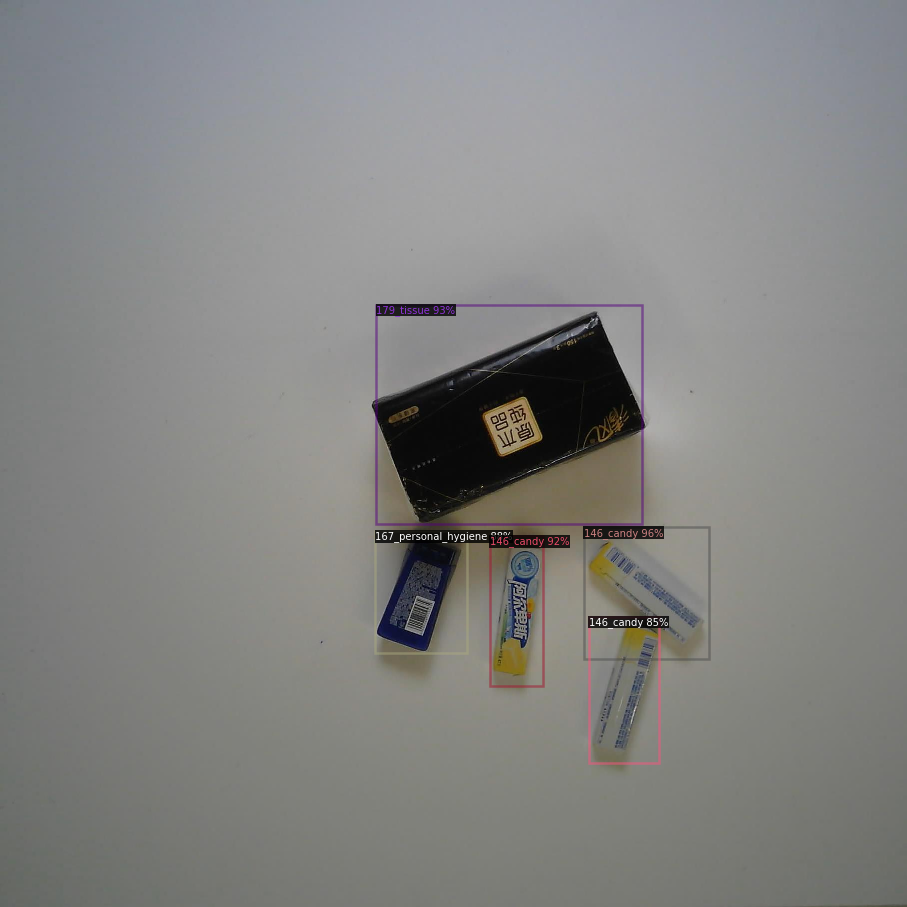

['146_candy', '179_tissue', '146_candy', '167_personal_hygiene', '146_candy']
/content/drive/My Drive/TECHNOUTSAV/testdata2019/20180905-09-42-10-3311.jpg


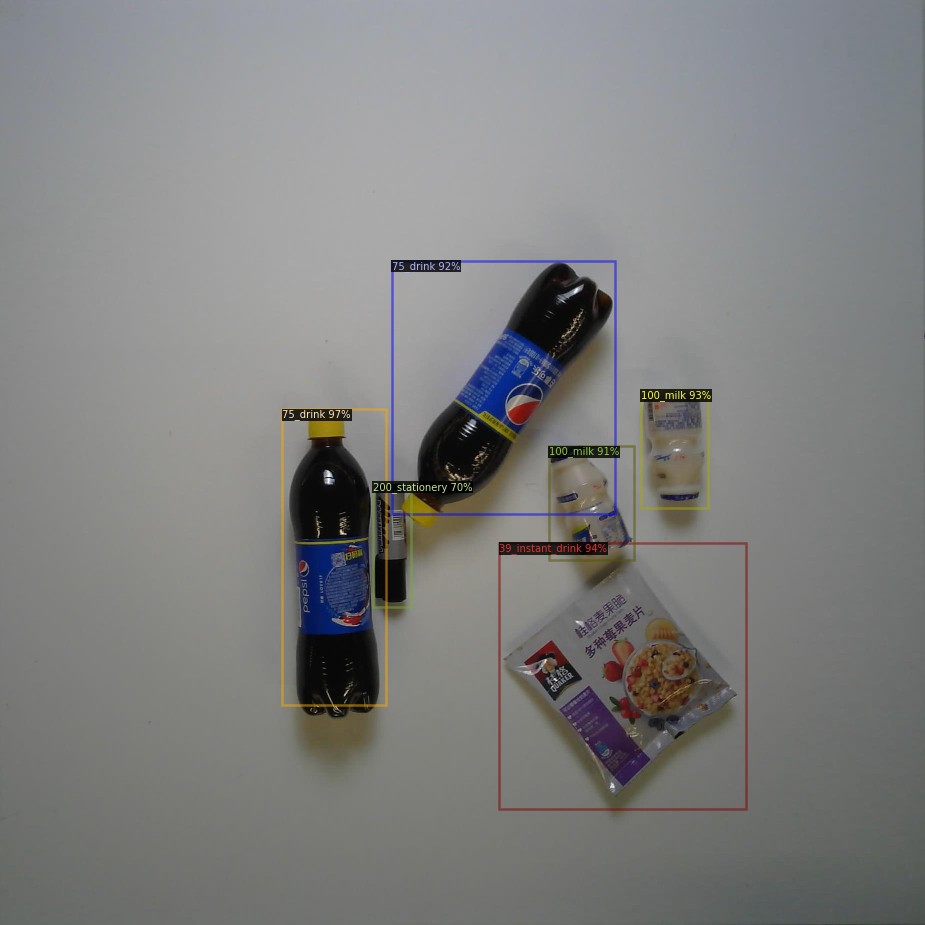

['75_drink', '39_instant_drink', '100_milk', '75_drink', '100_milk', '200_stationery']
/content/drive/My Drive/TECHNOUTSAV/testdata2019/20181022-14-14-49-3226.jpg


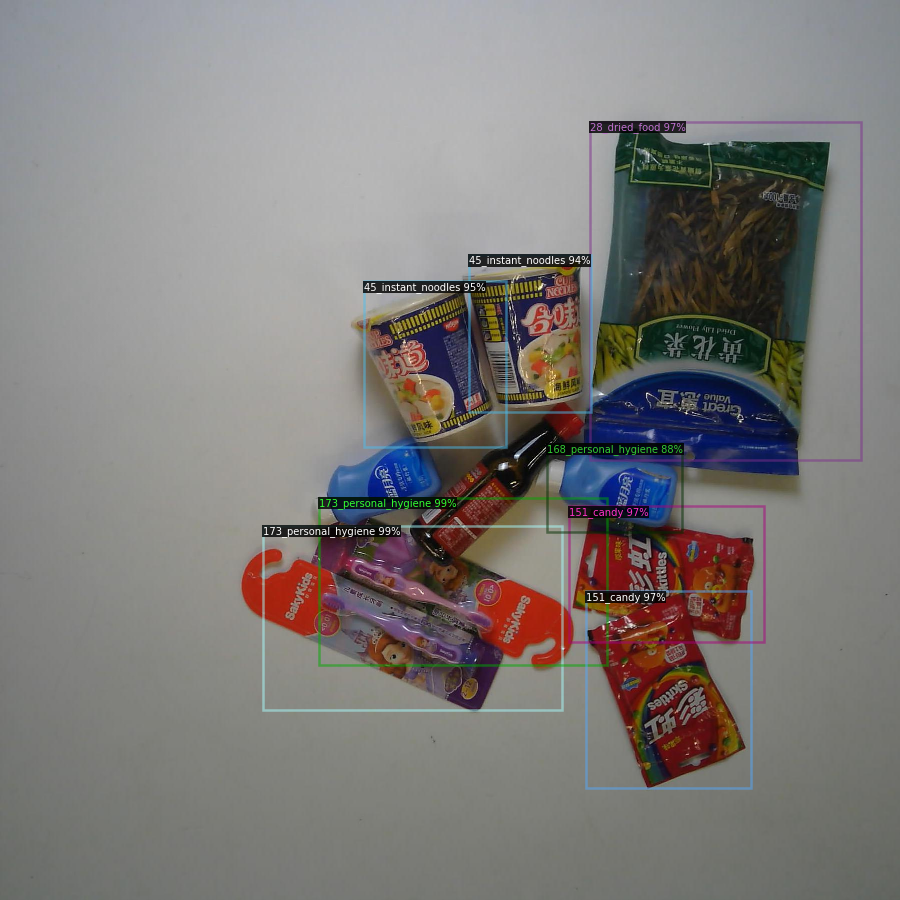

['173_personal_hygiene', '173_personal_hygiene', '151_candy', '28_dried_food', '151_candy', '45_instant_noodles', '45_instant_noodles', '168_personal_hygiene']


In [0]:
# Visualizing detections in images randomly sampled from the test set  
dataset_dicts = DatasetCatalog.get("rpc_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(d["file_name"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=rpc_test_metadata, 
                   scale=0.5, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    items = outputs["instances"].pred_classes.cpu().detach().numpy()
    items = list(items)
    print(create_list(items))

In [0]:
# Running inference on test data, to get test metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("rpc_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "rpc_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/23 14:36:07 d2.data.datasets.coco]: Loading /content/drive/My Drive/TECHNOUTSAV/test.json takes 1.49 seconds.
[03/23 14:36:07 d2.data.datasets.coco]: Loaded 6000 images in COCO format from /content/drive/My Drive/TECHNOUTSAV/test.json
[03/23 14:36:07 d2.data.build]: Distribution of instances among all 200 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| 1_puffed_food | 252          | 2_puffed_food | 421          | 3_puffed_food | 230          |
| 4_puffed_food | 474          | 5_puffed_food | 347          | 6_puffed_food | 433          |
| 7_puffed_food | 465          | 8_puffed_food | 516          | 9_puffed_food | 355          |
| 10_puffed_f.. | 407          | 11_puffed_f.. | 531          | 12_puffed_f.. | 332          |
| 13_dried_fr.. | 331          | 14_dried_fr.. | 317          | 15_dried_fr.. | 418          |
| 16_dried_f

OrderedDict([('bbox',
              {'AP': 63.41137853624544,
               'AP-100_milk': 67.61426785507774,
               'AP-101_milk': 61.24324559159825,
               'AP-102_milk': 72.76807333829439,
               'AP-103_milk': 64.22930227998296,
               'AP-104_milk': 70.42847212337193,
               'AP-105_milk': 67.15403107392346,
               'AP-106_milk': 66.3625295800904,
               'AP-107_milk': 65.83799373981837,
               'AP-108_canned_food': 29.57021919052422,
               'AP-109_canned_food': 70.43569348600863,
               'AP-10_puffed_food': 80.30368380865832,
               'AP-110_canned_food': 80.43704576812625,
               'AP-111_canned_food': 59.074355392360836,
               'AP-112_canned_food': 67.17085972481975,
               'AP-113_canned_food': 74.25263823057074,
               'AP-114_canned_food': 55.93666210204604,
               'AP-115_canned_food': 58.97289955137421,
               'AP-116_canned_food': 71.268